In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("test.csv", encoding = "ISO-8859-1")

In [ ]:
print("Nulls in training dataset",train.isnull().sum())
print("\nNulls in test dataset",test.isnull().sum())

Nulls in training dataset id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Nulls in test dataset id              0
comment_text    0
dtype: int64


In [ ]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

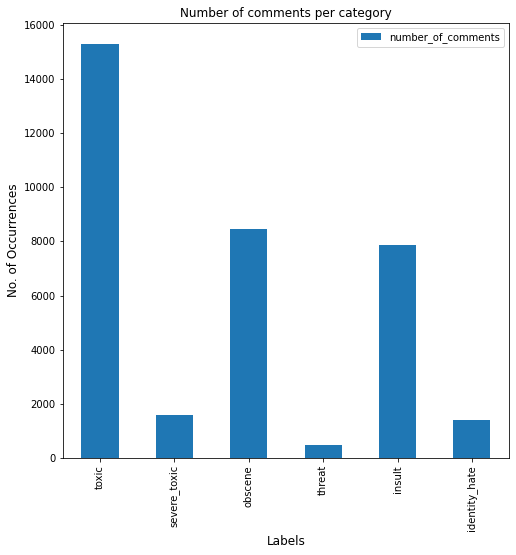

In [ ]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


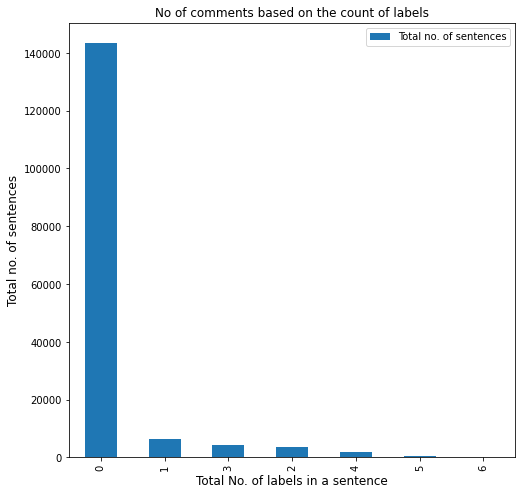

In [ ]:
### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

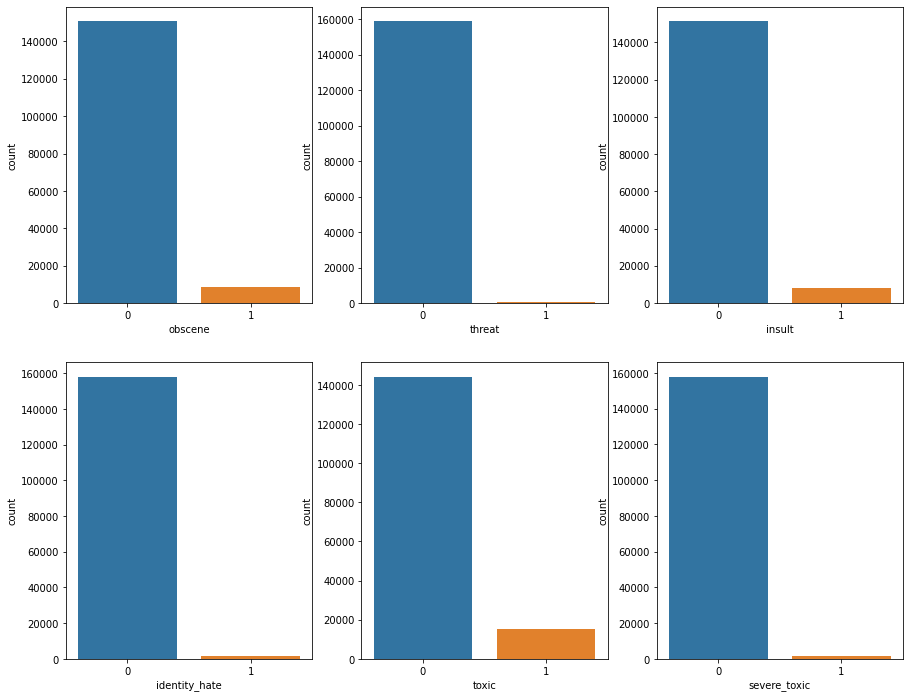

In [ ]:
### Graph of individual class against the total no. of labelled and unlabelled sentences for the same class

fig, plots = plt.subplots(2,3,figsize=(15,12))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(train['obscene'], ax = plot1)
sns.countplot(train['threat'], ax = plot2)
sns.countplot(train['insult'], ax = plot3)
sns.countplot(train['identity_hate'], ax = plot4)
sns.countplot(train['toxic'], ax = plot5)
sns.countplot(train['severe_toxic'], ax = plot6)

### From this graph it can be concluded that every class(category) is having higher no. of unlabelled sentences(0) as compared
### to labelled sentences(1)

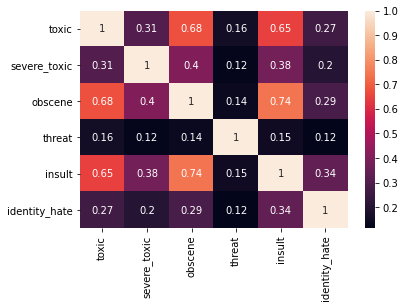

In [ ]:
### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)      ### conversion of contraction words to expanded words
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)                                                 ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])    ### Stopwords removal
    return text

train["comment_text"] = train["comment_text"].apply(clean_text)
test["comment_text"] = test["comment_text"].apply(clean_text)

In [ ]:
### Splitting up the labels and data
### Training dataset is splitted into 2 parts. 1st part includes the training data(train_data) and 2nd part includes labels(train_label) 
### associated with the training data
### Test dataset is having only 1 part i.e. test data which is used to predict the labels. 

train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]

In [ ]:
### Creating corpus of words and coverting it into integer and then susbstituing it in sentences - prepare tokenizer
tokenizer = Tokenizer(num_words = 40000) #40000 words are used here
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

In [ ]:
### Padding - Every sentence is unequal in length. We need to have all the sentence equal in lengths
### If length of sentence is less than 150 then padding will increase sentence length to 150 by adding zeros, if its greater
### than 150 then it will reduce the length of sentence to 150 by trimming the words

train_padded =pad_sequences(train_final, maxlen=150)
test_padded =pad_sequences(test_final, maxlen=150)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)

Shape of training data (159571, 150)
Shape of testing data (153164, 150)


In [ ]:
### I have built a sequential model using LSTM. Initial layer contains a word embedding layer having 128 hidden units. 
### Input to the LSTM model is given in the shape of an array of (159571, 150). There are 6 main classes and every class is having 2 sub classes.
### For every Input observation, there are 6 labels. 
### I have used 2 LSTM layer with 64 hidden units. 1 Dense layer which is an output layer. Dropout probability is set to 0.2 for
### 2 lSTM layers which will dropout the 20 percent of neuron automatically while training.Dropout resolves the problem of overfitting. 
### Output layer contains 6 hidden units. I have used sigmoid activation function in the output layer. The reason behind using
### sigmoid activation function in the output layer is because we have multi label classification problem.
### Every class(label) is having 2 more classes i.e.0 and 1 to predict. 

model = Sequential()
model.add(Embedding(40000, 128))
model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         5120000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 5,202,822
Trainable params: 5,202,822
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, shuffle = True, random_state = 123)
model.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 302s 72ms/step - loss: 0.1030 - auc: 0.8953 - val_loss: 0.0477 - val_auc: 0.9811


In [ ]:
### Prediction for test data
predict = model.predict(test_padded)

In [ ]:
print("Predicted values are",predict)

Predicted values are [[9.6421909e-01 1.0309325e-01 8.3110553e-01 4.1128635e-02 6.6258150e-01
  1.0575307e-01]
 [3.4433242e-03 6.9340029e-05 2.7709838e-04 2.5707259e-04 4.9927755e-04
  2.6749354e-04]
 [4.6960000e-02 3.7879567e-04 3.2808117e-03 1.4393787e-03 7.4722869e-03
  2.5388170e-03]
 ...
 [3.3107731e-03 6.4165222e-05 2.5542665e-04 2.3857674e-04 4.5718515e-04
  2.4235596e-04]
 [5.1759151e-03 8.2347120e-05 3.6534647e-04 3.3185360e-04 6.8760273e-04
  3.5364265e-04]
 [9.4379985e-01 6.6153094e-02 6.9861281e-01 4.2813271e-02 5.6541699e-01
  8.6149544e-02]]


In [ ]:
### predicted probabilities of each id in the test set, for all the target columns

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.964219,0.103093,0.831106,0.041129,0.662582,0.105753
1,0000247867823ef7,0.003443,0.000069,0.000277,0.000257,0.000499,0.000267
2,00013b17ad220c46,0.046960,0.000379,0.003281,0.001439,0.007472,0.002539
3,00017563c3f7919a,0.003033,0.000061,0.000236,0.000233,0.000428,0.000236
4,00017695ad8997eb,0.008769,0.000124,0.000635,0.000476,0.001272,0.000597


In [ ]:
final_predict_test.to_csv('submission.csv', index=False)

In [ ]:
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,second time asking view completely contradicts...,0,0,0,0,0,0
159567,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm theres actual article prostitution...,0,0,0,0,0,0
159569,fff125370e4aaaf3,looks like actually put speedy first version d...,0,0,0,0,0,0


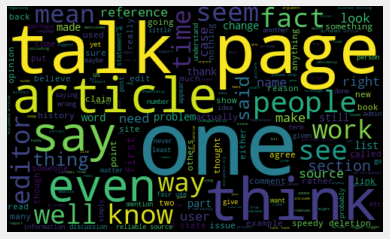

In [ ]:
#Word Cloud Visualization
allWords = ' '.join([twts for twts in train['comment_text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

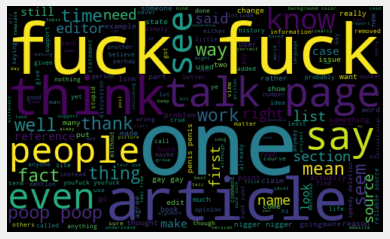

In [ ]:
#Word Cloud Visualization
allWords = ' '.join([twts for twts in test['comment_text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()